In [1]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './gorilla_monkey_dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 5


In [ ]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
        return features, labels
    
train_features, train_labels = extract_features(train_dir, 100)
validation_features, validation_labels = extract_features(validation_dir, 50)
test_features, test_labels = extract_features(test_dir, 50)

In [ ]:
train_features = np.reshape(train_features, (100, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (50, 4 * 4 * 512))
test_features = np.reshape(test_features, (50, 4 * 4 * 512))

In [4]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=20,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(150, 150),
batch_size = 5,
class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
validation_dir,
target_size=(150, 150),
batch_size = 5,
class_mode='binary')

Found 100 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [6]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5),
    metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=20,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=10)

C:\Users\lsh92\anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
C:\Users\lsh92\AppData\Local\Temp/ipykernel_9540/3513582271.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
20/20 [==============================] - 14s 599ms/step - loss: 0.6129 - acc: 0.7000 - val_loss: 0.5372 - val_acc: 0.7800
Epoch 2/30
20/20 [==============================] - 11s 577ms/step - loss: 0.4902 - acc: 0.8200 - val_loss: 0.4421 - val_acc: 0.8200
Epoch 3/30
20/20 [==============================] - 12s 587ms/step - loss: 0.3689 - acc: 0.9200 - val_loss: 0.3498 - val_acc: 0.8400
Epoch 4/30
20/20 [==============================] - 11s 580ms/step - loss: 0.2936 - acc: 0.8900 - val_loss: 0.3212 - val_acc: 0.8800
Epoch 5/30
20/20 [==============================] - 11s 558ms/step - loss: 0.2115 - acc: 0.9300 - val_loss: 0.2463 - val_acc: 0.9000
Epoch 6/30
20/20 [==============================] - 12s 584ms/step - loss: 0.1980 - acc: 0.9400 - val_loss: 0.2417 - val_acc: 0.8800
Epoch 7/30
20/20 [==============================] - 11s 570ms/step - loss: 0.1618 - acc: 0.9500 - val_loss: 0.1990 - val_acc: 0.9400
Epoch 8/30
20/20 [==============================] - 11s 567ms/step - 

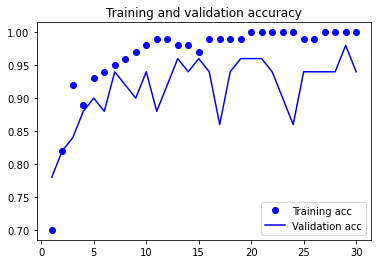

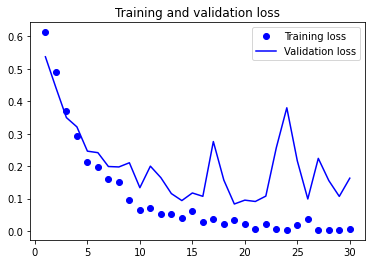

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

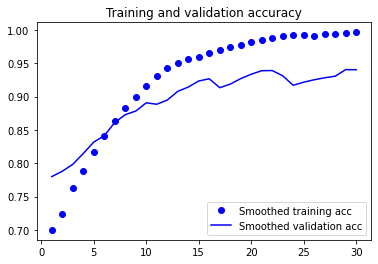

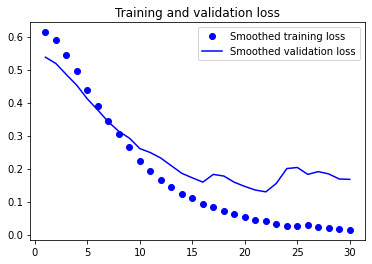

In [8]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [9]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=5,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=10)
print('test acc:', test_acc)

Found 50 images belonging to 2 classes.


C:\Users\lsh92\AppData\Local\Temp/ipykernel_9540/1112087655.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps=10)


test acc: 0.9599999785423279
